In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import seaborn as sns


sns.set(style="whitegrid")
palette = sns.color_palette("husl", 8)
ITALIAN_COLOR = sns.color_palette("husl", 8)[0]
ENGLISH_COLOR = sns.color_palette("husl", 8)[3]

## Imports

In [6]:
!python -m spacy download it_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 69.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('it_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 41.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [1]:
!pip install --upgrade numpy==1.26.4 scikit-learn==1.3.2 tweetopic==0.4.0
!pip install --force-reinstall scipy==1.11.4  # Совместимая версия scipy

# Перезагружаем рантайм
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 21.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.8 MB/s eta 0:00:00
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metad

{'status': 'ok', 'restart': True}

In [4]:
import pandas as pd
import re
import spacy
from spacy.language import Language
import numpy as np
from tqdm import tqdm
from collections import deque

import matplotlib.pyplot as plt
import seaborn as sns

from tweetopic import DMM
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics.pairwise import cosine_similarity

## Verbs lists

### Italian

In [ ]:
italian_verbs = ['toccare', 'sfiorare', 'colpire', 'urtare', 'sbattere', 'tamponare',
                'scontrarsi', 'spingere', 'spintonare', 'schiaffeggiare', 'calciare',
                'leccare', 'baciare', 'frustare', 'punzecchiare', 'pungere', 'schiacciare',
                'premere', 'cliccare', 'appoggiare', 'poggiare'
                 ]

In [ ]:
italian_to_russian = {
    "toccare": "тронуть",
    "sfiorare": "коснуться",
    "colpire": "ударить",
    "urtare": "удариться",
    "sbattere": "удариться",
    "tamponare": "врезаться",
    "scontrarsi": "столкнуться",
    "spingere": "толкнуть",
    "spintonare": "толкнуть",
    "schiaffeggiare": "шлёпнуть",
    "calciare": "пнуть",
    "leccare": "лизнуть",
    "baciare": "поцеловать",
    "frustare": "хлестнуть",
    "punzecchiare": "кольнуть",
    "pungere": "кольнуть",
    "schiacciare": "нажать",
    "premere": "нажать",
    "cliccare": "кликнуть",
    "appoggiare": "приложить",
    "poggiare": "приложить"
}

### English

In [ ]:
english_verbs = ['touch', 'hit', 'strike', 'beat', 'bang', 'bash', 'punch', 'whack',
                 'kick', 'smack', 'slap', 'swat', 'pat', 'tap', 'push', 'shove',
                 'crash', 'bump', 'collide', 'graze', 'nick'
                 ]

In [ ]:
english_to_russian = {
    "touch": "тронуть",
    "hit": "ударить",
    "strike": "ударить",
    "beat": "ударить",
    "bang": "ударить",
    "bash": "разбить",
    "punch": "ударить",
    "whack": "шлёпнуть",
    "kick": "пнуть",
    "smack": "шлёпнуть",
    "slap": "пощечина",
    "swat": "поймать",
    "pat": "погладить",
    "tap": "постучать",
    "push": "толкнуть",
    "shove": "толкнуть",
    "crash": "разбиться",
    "bump": "столкнуться",
    "collide": "столкнуться",
    "graze": "коснуться",
    "nick": "царапнуть"
}

## Italian Data

In [ ]:
italian_df = pd.read_csv("/content/drive/MyDrive/Диплом бакалавриат'25/final_italian_data.csv")

Мы проверим файл на наличие дублирующихся строк и очистим его от них, сохранив только первое вхождение. Этот шаг необходим, поскольку создатели датасетов предоставили минимальную информацию о данных, и мы стремимся обеспечить уникальность каждого контекста для дальнейшего анализа.


In [ ]:
any(italian_df.duplicated(subset=['text', 'found_verbs']))

True

In [ ]:
italian_df = italian_df.drop_duplicates(subset=['text', 'found_verbs'])

In [ ]:
any(italian_df.duplicated(subset=['text', 'found_verbs']))

False

Таким образом, мы получили...

In [ ]:
len(italian_df)

21443

### Анализ длин документов

Сначала мы посмотрим на длины текстов. Наши данные получены из социальной сети, где преобладают короткие сообщения, однако важно точно понимать распределение длин текстов.

In [ ]:
def preprocess_tweet(tweet):
    """Preprocess a tweet by removing hashtags, mentions"""
    tweet = tweet.lower()
    tweet = re.sub(r'#\w+', '', tweet)
    tweet = re.sub(r'@\w+', '', tweet)
    tweet = re.sub(r'[^\w\s]', '', tweet)
    tweet = re.sub(r'\s+', ' ', tweet).strip()
    return tweet

In [ ]:
italian_df['cleaned_text'] = italian_df['text'].apply(preprocess_tweet)

Разделим каждое сообщение на токены при помощи моделей spaCy

In [ ]:
nlp = spacy.load("it_core_news_sm", disable=["parser", "ner", "lemmatizer"])

def process_texts_with_progress(dataframe, text_column, batch_size=1000):
    """Process texts with SpaCy tokenization and real-time progress tracking."""
    texts = dataframe[text_column].tolist()

    return [
        len([token for token in doc if not token.is_punct])
        for doc in tqdm(
            nlp.pipe(texts, batch_size=batch_size),
            total=len(texts),
            desc="Tokenizing Italian texts",
            unit="doc"
        )
    ]

italian_df['spacy_word_count'] = process_texts_with_progress(italian_df, 'cleaned_text')

Tokenizing Italian texts: 100%|██████████| 21443/21443 [00:29<00:00, 727.02doc/s]


In [ ]:
lengths_italian_full = list(italian_df['spacy_word_count'])

# Основные статистики
min_length = np.min(lengths_italian_full)
max_length = np.max(lengths_italian_full)
mean_length = np.mean(lengths_italian_full)
std_length = np.std(lengths_italian_full)

print(f"Минимальная длина: {min_length}")
print(f"Максимальная длина: {max_length}")
print(f"Средняя длина: {mean_length:.2f}")
print(f"Стандартное отклонение: {std_length:.2f}")

Минимальная длина: 1
Максимальная длина: 59
Средняя длина: 25.33
Стандартное отклонение: 12.03


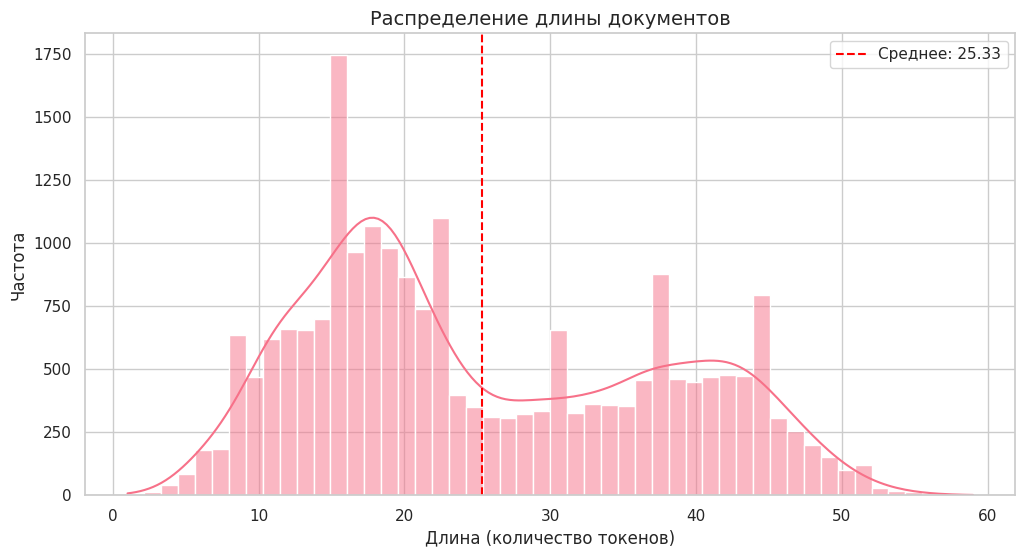

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(lengths_italian_full, bins=50, kde=True, color=ITALIAN_COLOR)
plt.title('Распределение длины документов', fontsize=14)
plt.xlabel('Длина (количество токенов)', fontsize=12)
plt.ylabel('Частота', fontsize=12)

plt.axvline(mean_length, color='red', linestyle='--', linewidth=1.5, label=f'Среднее: {mean_length:.2f}')

plt.legend()
plt.show()

Мы видим, что у нас есть сообщения и по 40, и по 50 токенов. Важно проверить, состоит ли этот текст из 1 длинного предложения, в котором встречается целевой глагол. В противном случае важно отфильтровать из сообщения предложения, которые не содержат целевой глагол. Так мы получим только релевантные контексты для дальнейшей векторизации.

In [ ]:
nlp = spacy.load("it_core_news_sm", disable=["ner", "textcat", "parser"])

# Кастомная функция для разделения предложений
@Language.component("custom_sentencizer")
def custom_sentencizer(doc):
    for i, token in enumerate(doc[:-1]):
        if token.text in [';', '\n'] or doc[i+1].text == '\n':
            doc[i+1].is_sent_start = True
    return doc

nlp.add_pipe("sentencizer")
nlp.add_pipe("custom_sentencizer", after="sentencizer")

def is_valid_sentence(sent, target_verbs):
    """Проверяем, содержит ли предложение ровно один целевой глагол (может повторяться)."""
    target_lemmas = set()

    for token in sent:
        if token.pos_ == "VERB":
            lemma = token.lemma_
            if lemma in target_verbs:
                target_lemmas.add(lemma)

    return len(target_lemmas) == 1

def process_text(row, target_verbs):
    """Обрабатываем текст и оставляем только предложения с ровно одним целевым глаголом."""
    doc = nlp(row['text'])
    results = []

    for sent in doc.sents:
        if is_valid_sentence(sent, target_verbs):
            results.append({
                **row.to_dict(),
                "context": sent.text,
                "context_type": "valid"
            })

    return results


In [ ]:
target_verbs = set(italian_verbs)
batch_size = 1000
contexts = []

for idx in tqdm(range(0, len(italian_df), batch_size), desc="Обработка"):
    batch = italian_df.iloc[idx:idx+batch_size]
    for _, row in batch.iterrows():
        contexts.extend(process_text(row, target_verbs))

Обработка: 100%|██████████| 22/22 [02:20<00:00,  6.39s/it]


In [ ]:
context_df = pd.DataFrame(contexts)
context_df = context_df.drop_duplicates(subset=['context'])

In [ ]:
context_df['context_type'].value_counts()

,count
context_type,
valid,20773


In [ ]:
any(context_df.duplicated(subset=['context']))

False

In [ ]:
len(context_df)

20773

Проанализируем распределение длин текстов на отфильтрованном датасете

In [ ]:
def preprocess_tweet(tweet):
    """Preprocess a tweet by removing hashtags, mentions"""
    tweet = tweet.lower()
    tweet = re.sub(r'#\w+', '', tweet)
    tweet = re.sub(r'@\w+', '', tweet)
    tweet = re.sub(r'[^\w\s]', '', tweet)
    tweet = re.sub(r'\s+', ' ', tweet).strip()
    return tweet

In [ ]:
context_df['cleaned_text'] = context_df['context'].apply(preprocess_tweet)

In [ ]:
nlp = spacy.load("it_core_news_sm", disable=["parser", "ner", "lemmatizer"])

def process_texts_with_progress(dataframe, text_column, batch_size=1000):
    """Process texts with SpaCy tokenization and real-time progress tracking."""
    texts = dataframe[text_column].tolist()

    return [
        len([token for token in doc if not token.is_punct])
        for doc in tqdm(
            nlp.pipe(texts, batch_size=batch_size),
            total=len(texts),
            desc="Tokenizing Italian texts",
            unit="doc"
        )
    ]

context_df['spacy_word_count'] = process_texts_with_progress(context_df, 'cleaned_text')

Tokenizing Italian texts: 100%|██████████| 20773/20773 [00:23<00:00, 894.99doc/s]


In [ ]:
lengths_italian_full = list(context_df['spacy_word_count'])

# Основные статистики
min_length = np.min(lengths_italian_full)
max_length = np.max(lengths_italian_full)
mean_length = np.mean(lengths_italian_full)
std_length = np.std(lengths_italian_full)

print(f"Минимальная длина: {min_length}")
print(f"Максимальная длина: {max_length}")
print(f"Средняя длина: {mean_length:.2f}")
print(f"Стандартное отклонение: {std_length:.2f}")

Минимальная длина: 1
Максимальная длина: 59
Средняя длина: 18.06
Стандартное отклонение: 10.05


In [ ]:
# Вычисляем квартили
q25 = np.percentile(lengths_italian_full, 25)
q50 = np.percentile(lengths_italian_full, 50)
q75 = np.percentile(lengths_italian_full, 75)

print(f"25-й квартиль: {q25:.2f}")
print(f"Медиана (50-й квартиль): {q50:.2f}")
print(f"75-й квартиль: {q75:.2f}")

25-й квартиль: 11.00
Медиана (50-й квартиль): 16.00
75-й квартиль: 23.00


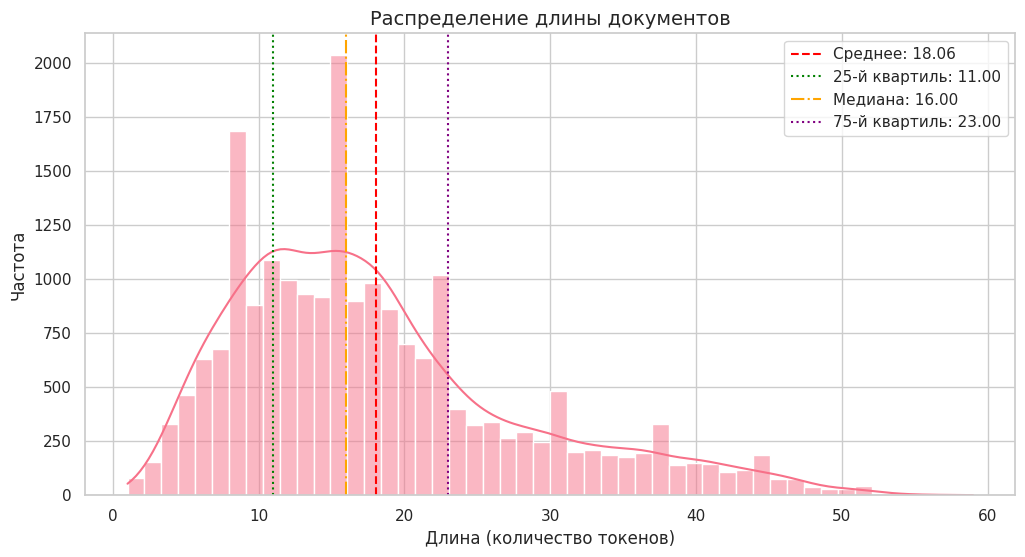

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(lengths_italian_full, bins=50, kde=True, color=ITALIAN_COLOR)
plt.title('Распределение длины документов', fontsize=14)
plt.xlabel('Длина (количество токенов)', fontsize=12)
plt.ylabel('Частота', fontsize=12)

plt.axvline(mean_length, color='red', linestyle='--', linewidth=1.5, label=f'Среднее: {mean_length:.2f}')
plt.axvline(q25, color='green', linestyle=':', linewidth=1.5, label=f'25-й квартиль: {q25:.2f}')
plt.axvline(q50, color='orange', linestyle='-.', linewidth=1.5, label=f'Медиана: {q50:.2f}')
plt.axvline(q75, color='purple', linestyle=':', linewidth=1.5, label=f'75-й квартиль: {q75:.2f}')

plt.legend()
plt.show()

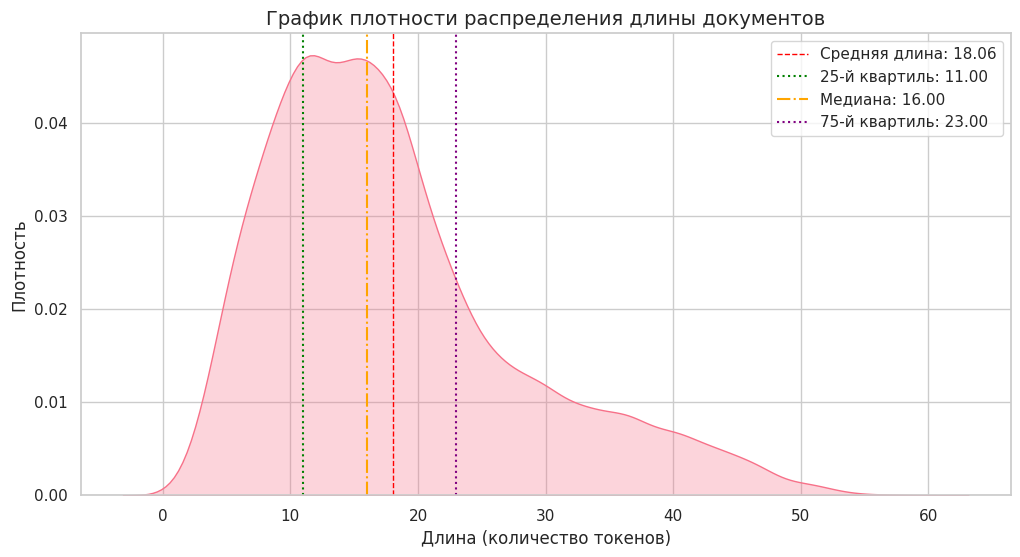

In [ ]:
# Построение графика распределения (density plot)
plt.figure(figsize=(12, 6))
sns.kdeplot(lengths_italian_full, fill=True, alpha=0.3, color=ITALIAN_COLOR)
plt.title('График плотности распределения длины документов', fontsize=14)
plt.xlabel('Длина (количество токенов)', fontsize=12)
plt.ylabel('Плотность', fontsize=12)

plt.axvline(mean_length, color='red', linestyle='dashed', linewidth=1, label=f'Средняя длина: {mean_length:.2f}')
plt.axvline(q25, color='green', linestyle=':', linewidth=1.5, label=f'25-й квартиль: {q25:.2f}')
plt.axvline(q50, color='orange', linestyle='-.', linewidth=1.5, label=f'Медиана: {q50:.2f}')
plt.axvline(q75, color='purple', linestyle=':', linewidth=1.5, label=f'75-й квартиль: {q75:.2f}')

plt.legend()
plt.show()

**Отфильтруем**

In [ ]:
context_df = context_df[(context_df['spacy_word_count'] >= 7) & (context_df['spacy_word_count'] <= 23)]

In [ ]:
len(context_df)

14310

Вновь проанализируем!

In [ ]:
lengths_italian_filtered = list(context_df['spacy_word_count'])

In [ ]:
# Основные статистики
min_length = np.min(lengths_italian_filtered)
max_length = np.max(lengths_italian_filtered)
mean_length = np.mean(lengths_italian_filtered)
std_length = np.std(lengths_italian_filtered)

print(f"Минимальная длина: {min_length}")
print(f"Максимальная длина: {max_length}")
print(f"Средняя длина: {mean_length:.2f}")
print(f"Стандартное отклонение: {std_length:.2f}")

Минимальная длина: 7
Максимальная длина: 23
Средняя длина: 14.53
Стандартное отклонение: 4.49


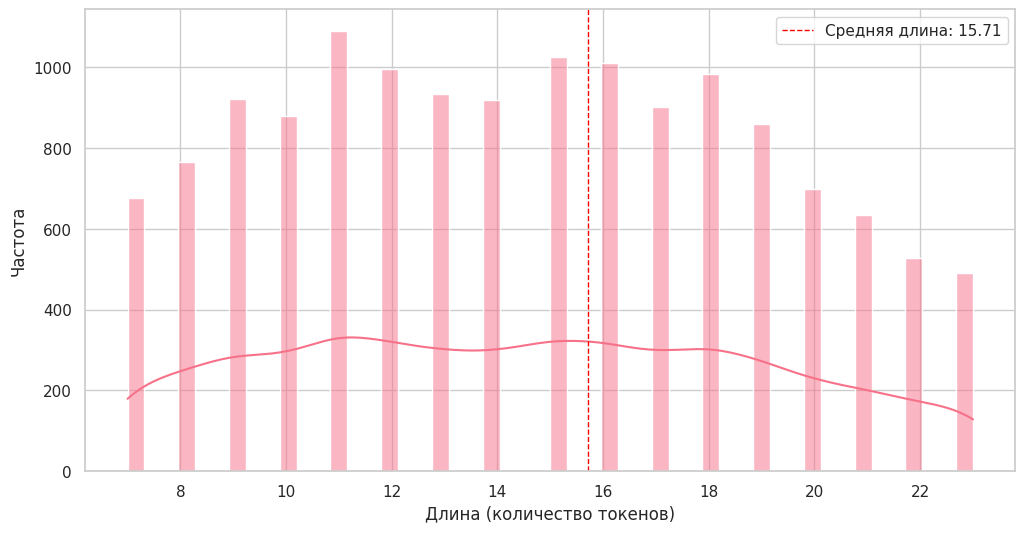

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(lengths_italian_filtered, bins=50, kde=True, color=ITALIAN_COLOR)
plt.title('Распределение длины документов', fontsize=14)
plt.xlabel('Длина (количество токенов)', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.axvline(mean_length, color='red', linestyle='dashed', linewidth=1, label=f'Средняя длина: {mean_length:.2f}')
plt.legend()
plt.show()

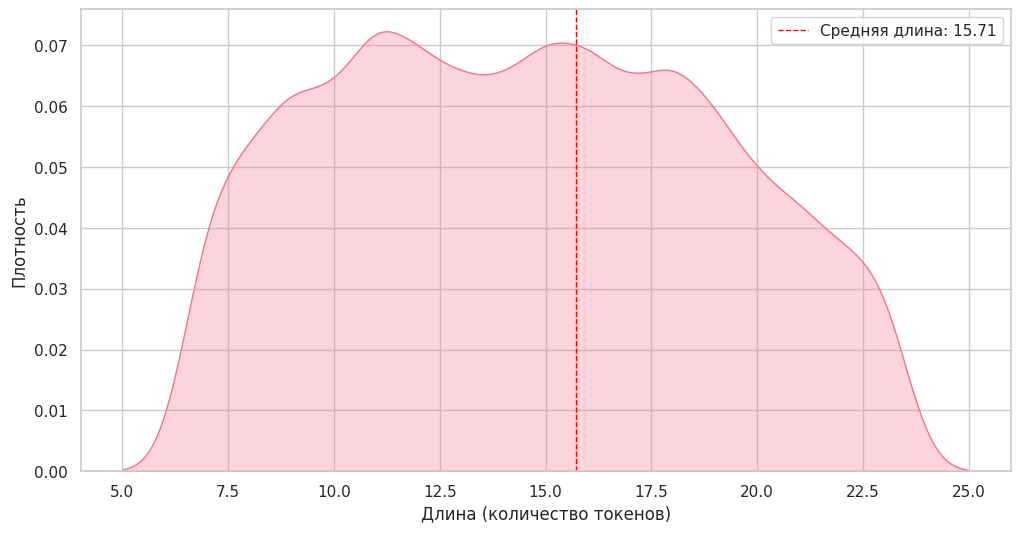

In [ ]:
# Построение графика распределения (density plot)
plt.figure(figsize=(12, 6))
sns.kdeplot(lengths_italian_filtered, fill=True, alpha=0.3, color=ITALIAN_COLOR)
plt.title('График плотности распределения длины документов', fontsize=16)
plt.xlabel('Длина (количество токенов)', fontsize=12)
plt.ylabel('Плотность', fontsize=12)
plt.axvline(mean_length, color='red', linestyle='dashed', linewidth=1, label=f'Средняя длина: {mean_length:.2f}')
plt.legend()
plt.show()

In [ ]:
context_df.to_csv("/content/drive/MyDrive/Диплом бакалавриат'25/final_italian_7to23.csv")

### Тематическое моделирование

In [5]:
context_df_it = pd.read_csv("/content/drive/MyDrive/Диплом бакалавриат'25/final_italian_7to23.csv")
context_df_it = context_df_it[['id', 'text', 'found_verbs', 'context', 'cleaned_text', 'spacy_word_count']]

In [7]:
nlp_it = spacy.load("it_core_news_sm", disable=["parser", "ner"])

In [8]:
def italian_preprocessor(text):
    doc = nlp_it(text)
    return " ".join([
        token.lemma_.lower()
        for token in doc
        if token.pos_ in ["NOUN", "VERB", "ADJ"]  # Фильтрация по частям речи
        and not token.is_stop
        and len(token.text) > 2
        and not token.like_url
        and not token.like_email
    ])

In [9]:
italian_vectorizer = CountVectorizer(
    min_df=15,
    max_df=0.1,
    preprocessor=italian_preprocessor,
    token_pattern=r'\b[a-zA-Z]{4,}\b'  # Фильтр коротких слов
)

italian_dmm = DMM(
    n_components=5,
    n_iterations=100,
    beta=0.1,
    alpha=0.3
)

italian_pipeline = Pipeline([
    ("vectorizer", italian_vectorizer),
    ("dmm", italian_dmm),
])

italian_pipeline.fit(context_df_it['context'])

Initializing components.


Sampling: 100%|██████████| 100/100 [00:07<00:00, 13.60it/s]


Pipeline(steps=[('vectorizer',
                 CountVectorizer(max_df=0.1, min_df=15,
                                 preprocessor=<function italian_preprocessor at 0x7ab777cb65c0>,
                                 token_pattern='\\b[a-zA-Z]{4,}\\b')),
                ('dmm', DMM(alpha=0.3, n_components=5, n_iterations=100))])

In [10]:
def merge_similar_topics(pipeline, similarity_threshold=0.6):
    components = pipeline.named_steps['dmm'].components_
    similarity_matrix = cosine_similarity(components)

    merged_topics = []
    used = set()

    for i in range(len(components)):
        if i not in used:
            similar = [j for j in range(i+1, len(components))
                      if similarity_matrix[i,j] > similarity_threshold]
            merged_topics.append(components[i] + sum(components[j] for j in similar))
            used.update(similar)

    pipeline.named_steps['dmm'].components_ = np.array(merged_topics)
    pipeline.named_steps['dmm'].n_components = len(merged_topics)

    return pipeline

italian_pipeline = merge_similar_topics(italian_pipeline)

In [11]:
def print_italian_top_terms(pipeline, n_terms=10):
    """Вывод топ-терминов для тем"""

    dmm_model = pipeline.named_steps['dmm']

    feature_names = pipeline.named_steps['vectorizer'].get_feature_names_out()

    print("\nТоп-термины по итальянским темам:")
    for topic_idx, topic_weights in enumerate(dmm_model.components_):
        top_features_indices = topic_weights.argsort()[:-n_terms-1:-1]
        top_features = [feature_names[i] for i in top_features_indices]
        print(f"Тема #{topic_idx + 1}: {', '.join(top_features)}")

print_italian_top_terms(italian_pipeline)


Топ-термины по итальянским темам:
Тема #1: tromboso, astrazeneca, morire, astrazeneco, ictus, cerebrale, donna, grave, genova, insegnante
Тема #2: sfiorare, dose, vaccinazione, quota, cliccare, somministrazione, coronavirus, vaccare, puglia, news
Тема #3: variante, cliccare, vaccinato, delto, leggere, bambino, vaccare, virus, terzo, info
Тема #4: tamponare, vaccinazione, sbattere, novax, appoggiare, virus, vaccinato, fare, leccare, andare
Тема #5: vaccinazione, vaccare, prenotazione, regione, anti, campagna, dose, fascia, giugno, fragile


In [12]:
context_df_it['topic'] = italian_pipeline.transform(context_df_it['context']).argmax(axis=1)
topic_counts = context_df_it['topic'].value_counts().sort_index()

In [13]:
topic_labels = ['Тема #1',
               'Тема #2',
               'Тема #3',
               'Тема #4',
               'Тема #5',
               ]

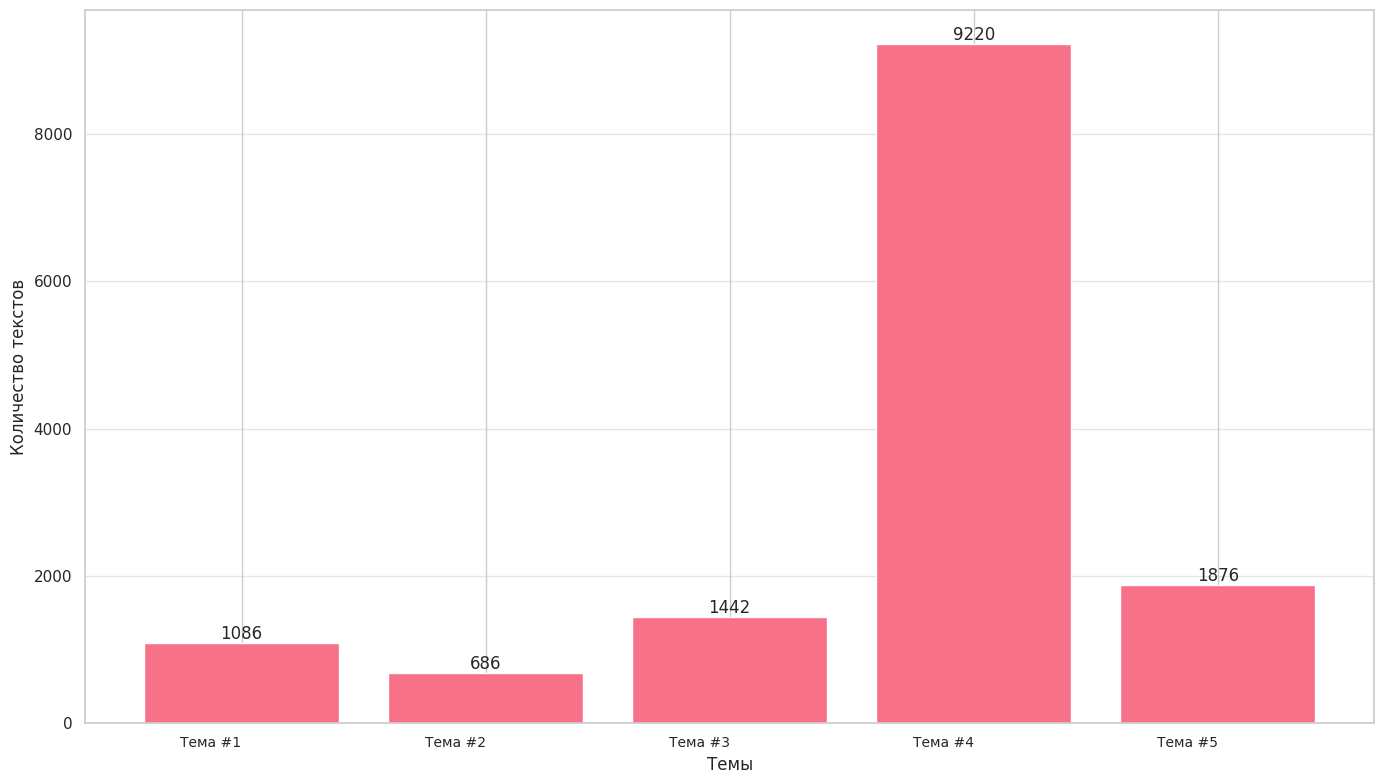

In [14]:
plt.figure(figsize=(14, 8))
bars = plt.bar(topic_counts.index, topic_counts.values, color=ITALIAN_COLOR)
plt.xlabel("Темы", fontsize=12)
plt.ylabel("Количество текстов", fontsize=12)

plt.xticks(
    ticks=topic_counts.index,
    labels=topic_labels,
    ha='right',
    fontsize=10
)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height}',
             ha='center', va='bottom')

plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()

In [15]:
context_df_it['found_verbs'].value_counts()

,count
found_verbs,
toccare (тронуть),3967
colpire (ударить),3925
spingere (толкнуть),2819
tamponare (врезаться),651
cliccare (кликнуть),499
appoggiare (приложить),462
sbattere (удариться),460
sfiorare (коснуться),394
premere (нажать),248


In [ ]:
context_df_it.to_csv("/content/drive/MyDrive/Диплом бакалавриат'25/final_italian_7to23.csv")

## English Data

In [ ]:
english_df = pd.read_csv("/content/drive/MyDrive/Диплом бакалавриат'25/final_english_data.csv")

Мы проверим файл на наличие дублирующихся строк и очистим его от них, сохранив только первое вхождение. Этот шаг необходим, поскольку создатели датасетов предоставили минимальную информацию о данных, и мы стремимся обеспечить уникальность каждого контекста для дальнейшего анализа.


In [ ]:
any(english_df.duplicated(subset=['tweet', 'found_verbs']))

In [ ]:
english_df = english_df.drop_duplicates(subset=['tweet', 'found_verbs'])

In [ ]:
any(english_df.duplicated(subset=['tweet', 'found_verbs']))

Таким образом, мы получили...

In [ ]:
len(english_df)

74015

### Анализ длин документов

Теперь проанализируем длины документов:

In [ ]:
def preprocess_tweet(tweet):
    """Preprocess a tweet by removing hashtags, mentions"""
    tweet = tweet.lower()
    tweet = re.sub(r'#\w+', '', tweet)
    tweet = re.sub(r'@\w+', '', tweet)
    tweet = re.sub(r'[^\w\s]', '', tweet)
    tweet = re.sub(r'\s+', ' ', tweet).strip()
    return tweet

In [ ]:
english_df['cleaned_text'] = english_df['tweet'].apply(preprocess_tweet)

Разделим каждое сообщение на токены при помощи моделей spaCy

In [ ]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner", "lemmatizer"])

def process_texts_with_progress(dataframe, text_column, batch_size=1000):
    """Process texts with SpaCy tokenization and real-time progress tracking."""
    texts = dataframe[text_column].tolist()

    return [
        len([token for token in doc if not token.is_punct])
        for doc in tqdm(
            nlp.pipe(texts, batch_size=batch_size),
            total=len(texts),
            desc="Tokenizing Italian texts",
            unit="doc"
        )
    ]

english_df['spacy_word_count'] = process_texts_with_progress(english_df, 'cleaned_text')

Tokenizing Italian texts: 100%|██████████| 74015/74015 [02:38<00:00, 467.11doc/s] 


In [ ]:
lengths_english_full = list(english_df['spacy_word_count'])

min_length = np.min(lengths_english_full)
max_length = np.max(lengths_english_full)
mean_length = np.mean(lengths_english_full)
std_length = np.std(lengths_english_full)

print(f"Минимальная длина: {min_length}")
print(f"Максимальная длина: {max_length}")
print(f"Средняя длина: {mean_length:.2f}")
print(f"Стандартное отклонение: {std_length:.2f}")

Минимальная длина: 0
Максимальная длина: 68
Средняя длина: 27.08
Стандартное отклонение: 13.58


In [ ]:
# Вычисляем квартили
q25 = np.percentile(lengths_english_full, 25)
q50 = np.percentile(lengths_english_full, 50)
q75 = np.percentile(lengths_english_full, 75)

print(f"25-й квартиль: {q25:.2f}")
print(f"Медиана (50-й квартиль): {q50:.2f}")
print(f"75-й квартиль: {q75:.2f}")

25-й квартиль: 16.00
Медиана (50-й квартиль): 25.00
75-й квартиль: 39.00


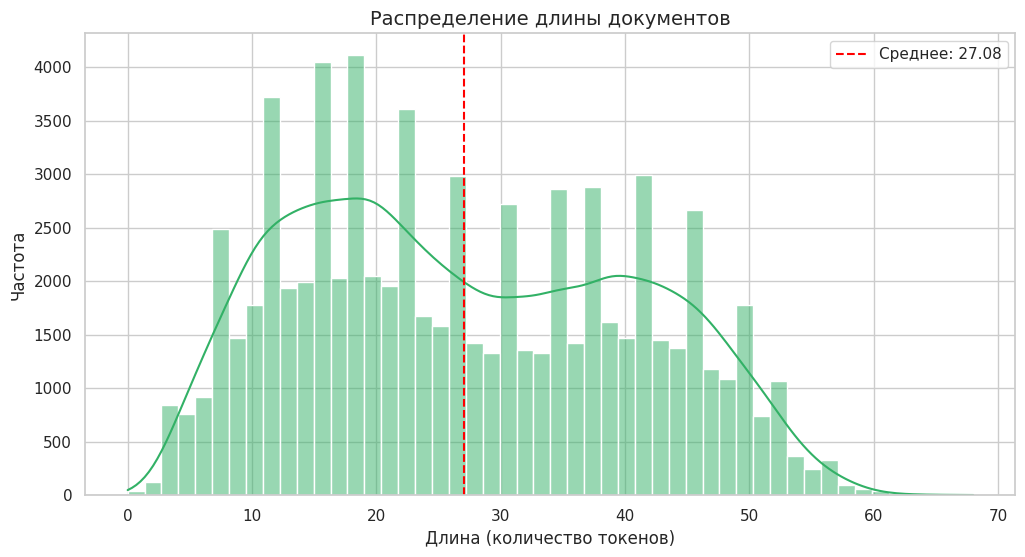

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(lengths_english_full, bins=50, kde=True, color=ENGLISH_COLOR)
plt.title('Распределение длины документов', fontsize=14)
plt.xlabel('Длина (количество токенов)', fontsize=12)
plt.ylabel('Частота', fontsize=12)

plt.axvline(mean_length, color='red', linestyle='--', linewidth=1.5, label=f'Среднее: {mean_length:.2f}')

plt.legend()
plt.show()

Данные демонстрируют преобладание коротких сообщений (10 – 25 токенов), что характерно для коммуникации в социальных сетях.  Однако в корпусе присутствуют и длинные тексты (≥ 40 токенов), содержащие несколько предложений. Часть из этих предложений не релевантна в нашем исследовании, т. к. не включает целевые глаголы. Учитывая, что далее мы будем векторизовать и кластеризовать контексты использования глаголов, т.е. сообщения, для выявления метафорических употреблений, критически важно исключить шум, вызванный нерелевантными фрагментами текстов. Для этого мы вводим дополнительный этап фильтрации на уровне предложений, заключающийся в изолировании предложений, включающих целевой глагол, от остального текста.

In [ ]:
nlp = spacy.load("en_core_web_sm", disable=["ner", "textcat", "parser"])

# Кастомная функция для разделения предложений
@Language.component("custom_sentencizer")
def custom_sentencizer(doc):
    for i, token in enumerate(doc[:-1]):
        if token.text in [';', '\n'] or doc[i+1].text == '\n':
            doc[i+1].is_sent_start = True
    return doc

nlp.add_pipe("sentencizer")
nlp.add_pipe("custom_sentencizer", after="sentencizer")

def is_valid_sentence(sent, target_verbs):
    """Проверяем, содержит ли предложение ровно один целевой глагол (может повторяться)."""
    target_lemmas = set()

    for token in sent:
        if token.pos_ == "VERB":
            lemma = token.lemma_
            if lemma in target_verbs:
                target_lemmas.add(lemma)

    return len(target_lemmas) == 1

def process_text(row, target_verbs):
    """Обрабатываем текст и оставляем только предложения с ровно одним целевым глаголом."""
    doc = nlp(row['tweet'])
    results = []

    for sent in doc.sents:
        if is_valid_sentence(sent, target_verbs):
            results.append({
                **row.to_dict(),
                "context": sent.text,
                "context_type": "valid"
            })

    return results


In [ ]:
target_verbs = set(english_verbs)
batch_size = 1000
contexts = []

for idx in tqdm(range(0, len(english_df), batch_size), desc="Обработка"):
    batch = english_df.iloc[idx:idx+batch_size]
    for _, row in batch.iterrows():
        contexts.extend(process_text(row, target_verbs))

Обработка: 100%|██████████| 75/75 [08:59<00:00,  7.19s/it]


In [ ]:
context_df = pd.DataFrame(contexts)
context_df = context_df.drop_duplicates(subset=['context'])

In [ ]:
context_df['context_type'].value_counts()

,count
context_type,
valid,74252


In [ ]:
any(context_df.duplicated(subset=['context']))

False

In [ ]:
len(context_df)

74252

Проанализируем распределение длин текстов на отфильтрованном датасете

In [ ]:
def preprocess_tweet(tweet):
    """Preprocess a tweet by removing hashtags, mentions"""
    tweet = tweet.lower()
    tweet = re.sub(r'#\w+', '', tweet)
    tweet = re.sub(r'@\w+', '', tweet)
    tweet = re.sub(r'[^\w\s]', '', tweet)
    tweet = re.sub(r'\s+', ' ', tweet).strip()
    return tweet

In [ ]:
context_df['cleaned_text'] = context_df['context'].apply(preprocess_tweet)

Разделим каждое сообщение на токены при помощи моделей spaCy

In [ ]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner", "lemmatizer"])

def process_texts_with_progress(dataframe, text_column, batch_size=1000):
    """Process texts with SpaCy tokenization and real-time progress tracking."""
    texts = dataframe[text_column].tolist()

    return [
        len([token for token in doc if not token.is_punct])
        for doc in tqdm(
            nlp.pipe(texts, batch_size=batch_size),
            total=len(texts),
            desc="Tokenizing English texts",
            unit="doc"
        )
    ]

context_df['spacy_word_count'] = process_texts_with_progress(context_df, 'cleaned_text')

Tokenizing English texts: 100%|██████████| 74252/74252 [01:33<00:00, 790.93doc/s] 


In [ ]:
lengths_english_full = list(context_df['spacy_word_count'])

min_length = np.min(lengths_english_full)
max_length = np.max(lengths_english_full)
mean_length = np.mean(lengths_english_full)
std_length = np.std(lengths_english_full)

print(f"Минимальная длина: {min_length}")
print(f"Максимальная длина: {max_length}")
print(f"Средняя длина: {mean_length:.2f}")
print(f"Стандартное отклонение: {std_length:.2f}")

Минимальная длина: 0
Максимальная длина: 68
Средняя длина: 15.71
Стандартное отклонение: 9.01


In [ ]:
context_df[context_df['spacy_word_count'] == 0]['context']

,context
11098,#BEATS
15260,#hits
16716,#BALTIC #ESTONIA #EUROPE #ICO #LITHUANIAN-#REG...
30941,\n\n#video #tv #musica #lunedi #hit
31787,#lunedì #hit #video #tv
36158,@ingentaconnect #push #abletonlive #secondarys...
44928,#Bump #Bump_Protocol #BSC #BSC_network
45277,#Vocal #Deep #House #Summer #Music #Mix #house...
47533,#newbeat #ukdrillbeat #ukdrill #beat #trap #be...
48052,#rap #beat #forsale


Видим, что нулевые контексты на самом деле нулевыми не являются. В них остались неинформативные хештеги, отделенные в процессе фильтарции.

In [ ]:
# Вычисляем квартили
q25 = np.percentile(lengths_english_full, 25)
q50 = np.percentile(lengths_english_full, 50)
q75 = np.percentile(lengths_english_full, 75)

print(f"25-й квартиль: {q25:.2f}")
print(f"Медиана (50-й квартиль): {q50:.2f}")
print(f"75-й квартиль: {q75:.2f}")

25-й квартиль: 9.00
Медиана (50-й квартиль): 14.00
75-й квартиль: 20.00


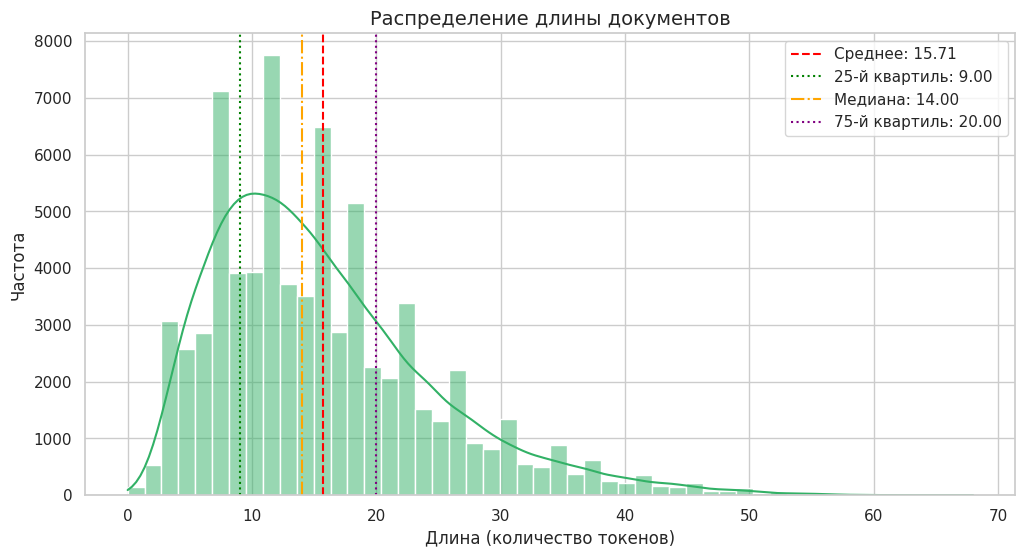

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(lengths_english_full, bins=50, kde=True, color=ENGLISH_COLOR)
plt.title('Распределение длины документов', fontsize=14)
plt.xlabel('Длина (количество токенов)', fontsize=12)
plt.ylabel('Частота', fontsize=12)

plt.axvline(mean_length, color='red', linestyle='--', linewidth=1.5, label=f'Среднее: {mean_length:.2f}')
plt.axvline(q25, color='green', linestyle=':', linewidth=1.5, label=f'25-й квартиль: {q25:.2f}')
plt.axvline(q50, color='orange', linestyle='-.', linewidth=1.5, label=f'Медиана: {q50:.2f}')
plt.axvline(q75, color='purple', linestyle=':', linewidth=1.5, label=f'75-й квартиль: {q75:.2f}')

plt.legend()
plt.show()

**Отфильтруем**

In [ ]:
context_df = context_df[(context_df['spacy_word_count'] >= 7) & (context_df['spacy_word_count'] <= 23)]

In [ ]:
len(context_df)

52198

In [ ]:
lengths_english_filtered = list(context_df['spacy_word_count'])

In [ ]:
# Основные статистики
min_length = np.min(lengths_english_filtered)
max_length = np.max(lengths_english_filtered)
mean_length = np.mean(lengths_english_filtered)
std_length = np.std(lengths_english_filtered)

print(f"Минимальная длина: {min_length}")
print(f"Максимальная длина: {max_length}")
print(f"Средняя длина: {mean_length:.2f}")
print(f"Стандартное отклонение: {std_length:.2f}")

Минимальная длина: 7
Максимальная длина: 23
Средняя длина: 13.87
Стандартное отклонение: 4.56


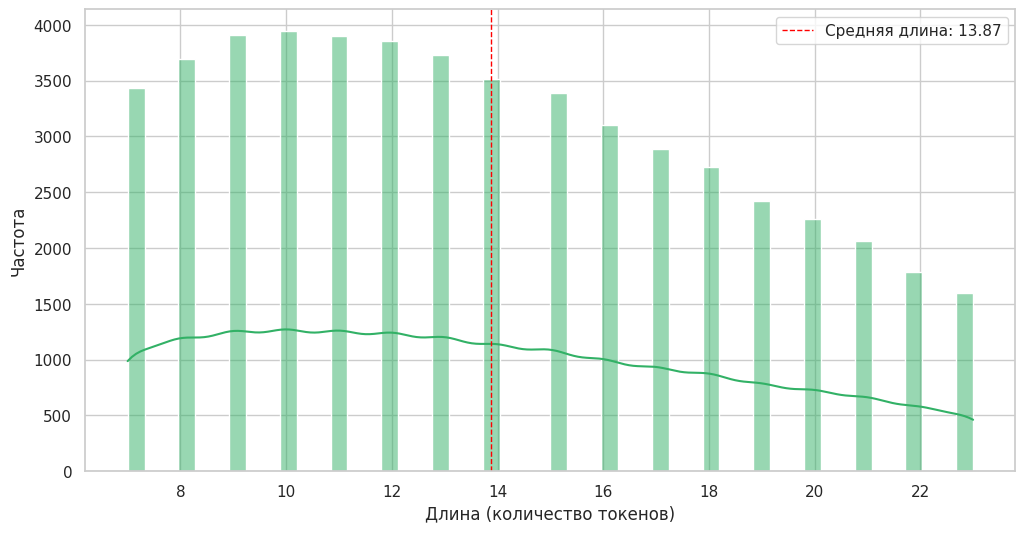

In [ ]:
sns.set(style="whitegrid")

# Построение гистограммы
plt.figure(figsize=(12, 6))
sns.histplot(lengths_english_filtered, bins=50, kde=True, color=ENGLISH_COLOR)
plt.title('Распределение длины документов', fontsize=16)
plt.xlabel('Длина (количество токенов)', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.axvline(mean_length, color='red', linestyle='dashed', linewidth=1, label=f'Средняя длина: {mean_length:.2f}')
plt.legend()
plt.show()

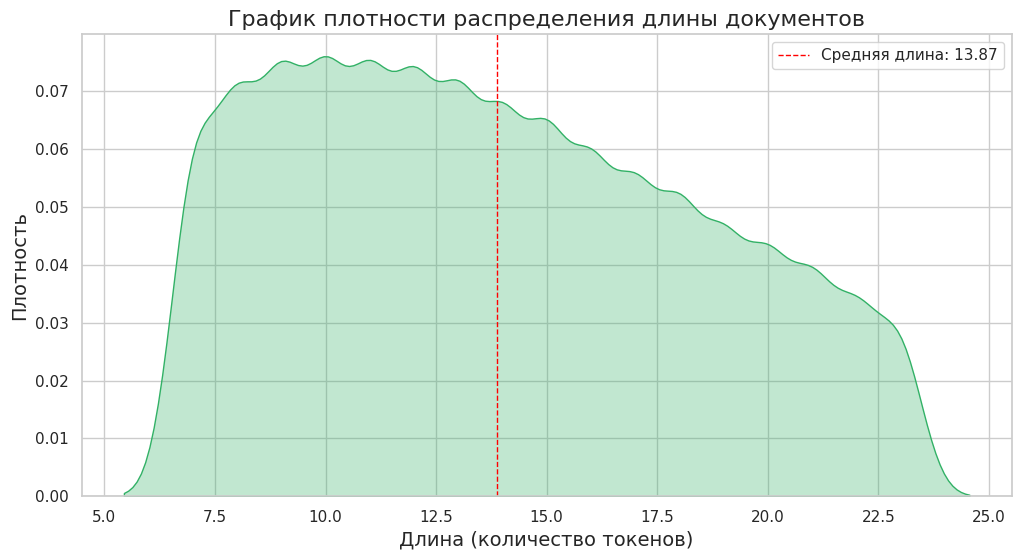

In [ ]:
# Построение графика распределения (density plot)
plt.figure(figsize=(12, 6))
sns.kdeplot(lengths_english_filtered, fill=True, alpha=0.3, color=ENGLISH_COLOR)
plt.title('График плотности распределения длины документов', fontsize=16)
plt.xlabel('Длина (количество токенов)', fontsize=14)
plt.ylabel('Плотность', fontsize=14)
plt.axvline(mean_length, color='red', linestyle='dashed', linewidth=1, label=f'Средняя длина: {mean_length:.2f}')
plt.legend()
plt.show()

In [ ]:
context_df.to_csv("/content/drive/MyDrive/Диплом бакалавриат'25/final_english_7to23.csv")

### Анализ временного промежутка

In [ ]:
context_df_en = pd.read_csv("/content/drive/MyDrive/Диплом бакалавриат'25/final_english_7to23.csv")
context_df_en = context_df_en[['user', 'id', 'tweet', 'date', 'found_verbs', 'context', 'cleaned_text', 'spacy_word_count']]

In [ ]:
context_df_en['date'] = pd.to_datetime(context_df_en['date'], utc=True)
context_df_en['year'] = context_df_en['date'].dt.year
context_df_en['month'] = context_df_en['date'].dt.month
context_df_en['year_month'] = context_df_en['date'].dt.to_period('M')

In [ ]:
year_dist = context_df_en['year'].value_counts().sort_index()
month_dist = context_df_en['month'].value_counts().sort_index()
year_month_dist = context_df_en['year_month'].value_counts().sort_index()

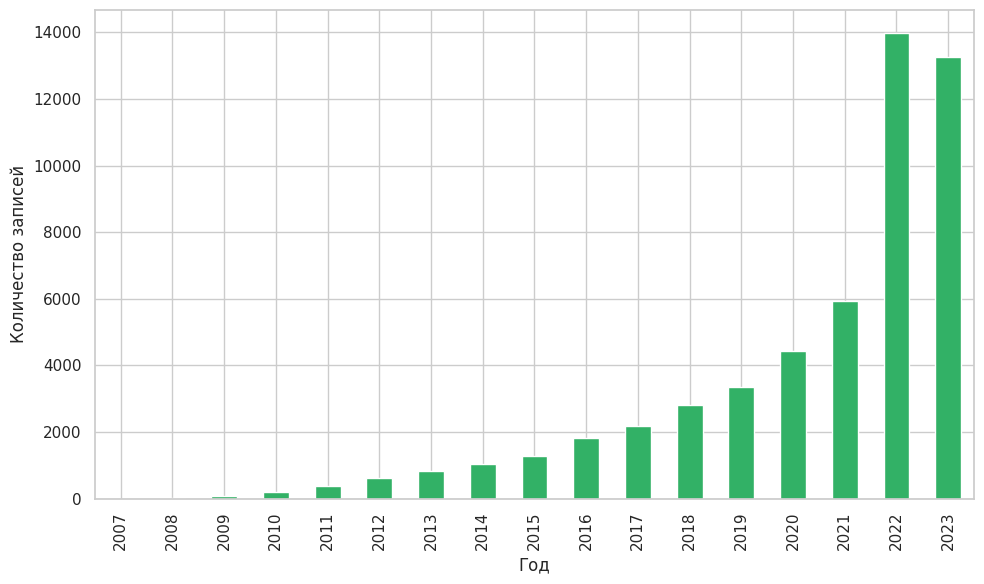

In [ ]:
plt.figure(figsize=(10, 6))

# Распределение по годам
year_dist.plot(kind='bar', color=ENGLISH_COLOR)
plt.xlabel('Год', fontsize=12)
plt.ylabel('Количество записей', fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
context_df_en = context_df_en.loc[
    (context_df_en['date'].dt.year >= 2020) &
    (context_df_en['date'].dt.year <= 2023)
]

In [ ]:
len(context_df_en)

37592

In [ ]:
context_df_en['year'].value_counts()

,count
year,
2022,13973
2023,13261
2021,5933
2020,4425


### Тематическое моделирование

In [ ]:
nlp_en = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def english_preprocessor(text):
    doc = nlp_en(text)
    return " ".join([
        token.lemma_.lower()
        for token in doc
        if token.pos_ in ["NOUN", "VERB", "ADJ"]
        and not token.is_stop
        and len(token.text) > 2
        and not token.like_url
        and not token.like_email
        and not token.is_punct
    ])

In [ ]:
english_vectorizer = CountVectorizer(
    min_df=15,
    max_df=0.1,
    preprocessor=english_preprocessor,
    token_pattern=r'\b[a-zA-Z]{3,}\b'
)

english_dmm = DMM(
    n_components=5,
    n_iterations=100,
    alpha=0.3,
    beta=0.1
)

english_pipeline = Pipeline([
    ("vectorizer", english_vectorizer),
    ("dmm", english_dmm),
])

english_pipeline.fit(context_df_en['context'])

Initializing components.


Sampling: 100%|██████████| 100/100 [00:02<00:00, 33.55it/s]


Pipeline(steps=[('vectorizer',
                 CountVectorizer(max_df=0.1, min_df=15,
                                 preprocessor=<function english_preprocessor at 0x79e87e8794e0>,
                                 token_pattern='\\b[a-zA-Z]{3,}\\b')),
                ('dmm', DMM(alpha=0.3, n_components=5, n_iterations=100))])

In [ ]:
def merge_similar_topics(pipeline, similarity_threshold=0.6):
    components = pipeline.named_steps['dmm'].components_
    similarity_matrix = cosine_similarity(components)

    merged_topics = []
    used = set()

    for i in range(len(components)):
        if i not in used:
            similar = [j for j in range(i+1, len(components))
                      if similarity_matrix[i,j] > similarity_threshold]
            merged_topics.append(components[i] + sum(components[j] for j in similar))
            used.update(similar)

    pipeline.named_steps['dmm'].components_ = np.array(merged_topics)
    pipeline.named_steps['dmm'].n_components = len(merged_topics)

    return pipeline

english_pipeline = merge_similar_topics(english_pipeline)

In [ ]:
def print_english_top_terms(pipeline, n_terms=10):
    """Вывод топ-терминов для тем"""

    dmm_model = pipeline.named_steps['dmm']

    feature_names = pipeline.named_steps['vectorizer'].get_feature_names_out()

    print("\nТоп-термины по английским темам:")
    for topic_idx, topic_weights in enumerate(dmm_model.components_):
        top_features_indices = topic_weights.argsort()[:-n_terms-1:-1]
        top_features = [feature_names[i] for i in top_features_indices]
        print(f"Тема #{topic_idx + 1}: {', '.join(top_features)}")

print_english_top_terms(english_pipeline)


Топ-термины по английским темам:
Тема #1: touch, strike, get, time, people, year, need, think, crash, know
Тема #2: new, today, tap, week, year, day, link, time, start, weekend
Тема #3: game, run, strike, win, time, team, season, goal, home, year
Тема #4: strike, crash, russian, car, kill, earthquake, missile, people, say, police


In [ ]:
context_df_en['topic'] = english_pipeline.transform(context_df_en['context']).argmax(axis=1)

In [ ]:
topic_counts = context_df_en['topic'].value_counts().sort_index()

In [ ]:
topic_labels = ['Тема #1',
                'Тема #2',
                'Тема #3',
                'Тема #4'
               ]

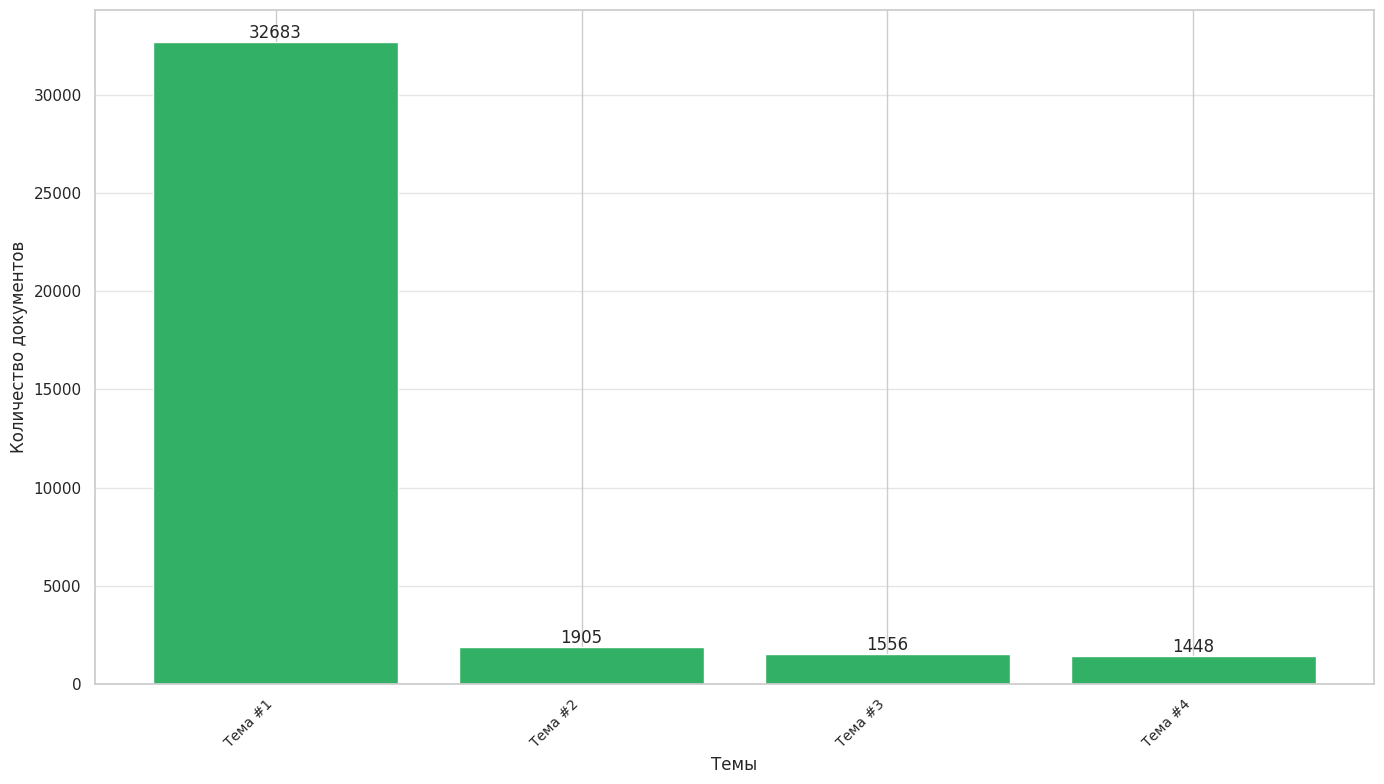

In [ ]:
plt.figure(figsize=(14, 8))
bars = plt.bar(topic_counts.index, topic_counts.values, color=ENGLISH_COLOR)
plt.xlabel("Темы", fontsize=12)
plt.ylabel("Количество документов", fontsize=12)

plt.xticks(
    ticks=topic_counts.index,
    labels=topic_labels,
    rotation=45,
    ha='right',
    fontsize=10
)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height}',
             ha='center', va='bottom')

plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
context_df_en = context_df_en[context_df_en['topic'] == 0]

In [17]:
context_df_en['found_verbs'].value_counts()

,count
found_verbs,
hit (ударить),9999
push (толкнуть),5633
beat (ударить),4456
kick (пнуть),4261
strike (ударить),2067
touch (тронуть),2025
crash (разбиться),823
tap (постучать),808
punch (ударить),510


In [ ]:
context_df_en.to_csv("/content/drive/MyDrive/Диплом бакалавриат'25/final_english_7to23.csv")